
# Кластеризация транзакций: несколько моделей и сравнение метрик

**Колонки, ожидаемые в данных:**  
`date, debit_account, debit_name, debit_inn, credit_account, credit_name, credit_inn, purpose`

В тетрадке:
- Загрузка/подготовка данных
- Построение фичей (текст, категориальные, даты)
- Обучение нескольких моделей кластеризации: KMeans, Agglomerative, DBSCAN, GaussianMixture
- Сравнение по метрикам: Silhouette, Calinski–Harabasz, Davies–Bouldin
- Визуализация кластеров (t-SNE 2D)
- Экспорт результатов


In [2]:

# == Импорт библиотек ==
import os
import re
import gc
import math
import numpy as np
import pandas as pd

from datetime import datetime

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import text as sk_text

from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt

pd.set_option('display.max_colwidth', 200)
random_state = 42


In [11]:

# == Загрузка данных ==
# Ожидается CSV с колонками из описания. По умолчанию ищем /mnt/data/transactions.csv.
# Можно заменить путь на ваш.

CSV_PATH = "new_data/real_data.csv"

def load_or_mock(csv_path):
    
    df = pd.read_csv(csv_path)
    
    return df

df = load_or_mock(CSV_PATH)
print("Форма данных:", df.shape)
df.head()


Форма данных: (2688, 11)


,Unnamed: 0,date,debit_account,debit_name,debit_inn,credit_account,credit_name,credit_inn,debit_amount,credit_amount,purpose
0,0,2019-01-09 19:01:15,DEBIT_ACC_ded93f97f389bf2c,DEBIT_NAME_b736fcdbf591b1c2,DEBIT_INN_d877722ca4e40f98,CREDIT_ACC_0c00203649ed677a,CREDIT_NAME_e19cc80da09f445f,CREDIT_INN_8d9e0be733f77f1c,10.0,NaN,Комиссия внутри Сбербанка за ПП/ПТ через ДБО согласно договору РКО № ACC_ded93f97f389 от '02/12/2014'. №1 (3000000 RUR ) от 09/01/19. Без НДС
1,1,2019-01-09 04:06:29,DEBIT_ACC_ded93f97f389bf2c,DEBIT_NAME_b736fcdbf591b1c2,DEBIT_INN_d877722ca4e40f98,CREDIT_ACC_7682fd5c32e028f5,CREDIT_NAME_796a88c244ffcc0a,CREDIT_INN_6931e23e98703aa9,3000000.0,NaN,Оплата по счету № 28 от DATE_9f241b636025 по договору №3-Тор от 19.05.18г аванс Сумма 3000000-00 В т.ч. НДС (18%) 457627-12
2,2,2019-01-10 15:54:17,DEBIT_ACC_ded93f97f389bf2c,DEBIT_NAME_b736fcdbf591b1c2,DEBIT_INN_d877722ca4e40f98,CREDIT_ACC_0c00203649ed677a,CREDIT_NAME_e19cc80da09f445f,CREDIT_INN_8d9e0be733f77f1c,10.0,NaN,Комиссия внутри Сбербанка за ПП/ПТ через ДБО согласно договору РКО № ACC_ded93f97f389 от '02/12/2014'. №2 (4282 RUR ) от 10/01/19. Без НДС
3,3,2019-01-10 06:08:48,DEBIT_ACC_ded93f97f389bf2c,DEBIT_NAME_b736fcdbf591b1c2,DEBIT_INN_d877722ca4e40f98,CREDIT_ACC_e63cf19b76230a3d,CREDIT_NAME_21a73421ca00ae87,CREDIT_INN_eed8b1f54ed4366c,4282.0,NaN,Оплата по договору Электроэнергия по дог.№112458 от 03.03.17 по сф 42411-080-02 от 31.12.18 аванс 70% за январь 2018г Сумма 4282-00 В т.ч. НДС (18%) 653-19
4,4,2019-01-10 07:30:56,DEBIT_ACC_d658b4e51c5a5df5,DEBIT_NAME_f7185cc66db08da5,DEBIT_INN_ad57c94e5b8df8f6,CREDIT_ACC_ded93f97f389bf2c,CREDIT_NAME_3e368a63959d285e,CREDIT_INN_d877722ca4e40f98,NaN,1000000.0,Перевод денежных средств по Договору займа № ЧИ-1/271218 от 27.12.2018г. Сумма 1000000-00 Без налога (НДС)


In [12]:

# == Вспомогательные функции для подготовки признаков ==

def _clean_text(s: pd.Series) -> pd.Series:
    s = s.astype(str).str.lower()
    s = s.str.replace(r"\s+", " ", regex=True)
    s = s.str.replace(r"[\n\r\t]+", " ", regex=True)
    return s.str.strip()

def _extract_date_features(s: pd.Series) -> pd.DataFrame:
    s = pd.to_datetime(s, errors="coerce")
    out = pd.DataFrame({
        "date_year": s.dt.year,
        "date_month": s.dt.month,
        "date_day": s.dt.day,
        "date_dow": s.dt.dayofweek,
        "date_week": s.dt.isocalendar().week.astype(int),
        "date_quarter": s.dt.quarter,
    })
    return out.fillna(0).astype(int)

def _as_str(s: pd.Series) -> pd.Series:
    return s.astype(str).fillna("")

def _date_features_input(x):
    import numpy as np, pandas as pd
    if isinstance(x, pd.DataFrame):
        s = x.iloc[:, 0]
    elif isinstance(x, pd.Series):
        s = x
    elif isinstance(x, np.ndarray):
        s = pd.Series(x[:, 0]) if x.ndim == 2 else pd.Series(x)
    else:
        s = pd.Series(x)
    return _extract_date_features(pd.Series(s))

date_ft = FunctionTransformer(_date_features_input, validate=False)


In [13]:

# == Построение пайплайна признаков ==

text_stop_words = sk_text.ENGLISH_STOP_WORDS  # добавим англ. стоп-слова; при желании можно расширить русскими

# Текстовые столбцы: purpose + имена контрагентов
text_cols = ["purpose", "debit_name", "credit_name"]

# Счет/ИНН — как идентификаторы: хэш-векторизация по символам, чтобы не плодить миллион фиктивных категорий
hash_cols = ["debit_account", "credit_account", "debit_inn", "credit_inn"]

# Дата
date_col = ["date"]

preprocess = ColumnTransformer([
    # Текст: TF-IDF (char+word)
    ("tfidf_purpose", TfidfVectorizer(
        preprocessor=None,
        tokenizer=None,
        lowercase=True,
        ngram_range=(1,2),
        min_df=2,
        max_features=30000
    ), "purpose"),
    ("tfidf_debit_name", TfidfVectorizer(
        preprocessor=None,
        tokenizer=None,
        lowercase=True,
        ngram_range=(1,2),
        min_df=2,
        max_features=20000
    ), "debit_name"),
    ("tfidf_credit_name", TfidfVectorizer(
        preprocessor=None,
        tokenizer=None,
        lowercase=True,
        ngram_range=(1,2),
        min_df=2,
        max_features=20000
    ), "credit_name"),
    # Идентификаторы: HashingVectorizer по символам
    ("hash_debit_acc", HashingVectorizer(
        n_features=2**12, alternate_sign=False, analyzer="char", ngram_range=(4,6)
    ), "debit_account"),
    ("hash_credit_acc", HashingVectorizer(
        n_features=2**12, alternate_sign=False, analyzer="char", ngram_range=(4,6)
    ), "credit_account"),
    ("hash_debit_inn", HashingVectorizer(
        n_features=2**10, alternate_sign=False, analyzer="char", ngram_range=(2,6)
    ), "debit_inn"),
    ("hash_credit_inn", HashingVectorizer(
        n_features=2**10, alternate_sign=False, analyzer="char", ngram_range=(2,6)
    ), "credit_inn"),
    # Дата -> числовые признаки
    ("date_feats", date_ft, ["date"]),
], remainder="drop", verbose_feature_names_out=False)

# Основной фичепайплайн: трансформер -> SVD для сжатия
feature_pipeline = Pipeline([
    ("prep", preprocess),
    ("svd", TruncatedSVD(n_components=50, random_state=42)),
    ("scale", StandardScaler())
])

# Подготовим также 2D-эмбеддинг для визуализации (t-SNE сверху над SVD 50d)
viz_pipeline = Pipeline([
    ("prep", preprocess),
    ("svd", TruncatedSVD(n_components=50, random_state=42)),
])


In [14]:

# == Построение матрицы признаков ==
work_df = df[[
    "date","debit_account","debit_name","debit_inn",
    "credit_account","credit_name","credit_inn","purpose"
]].copy()

# Очистка текстовых колонок для более устойчивого TF-IDF
for col in ["purpose","debit_name","credit_name","debit_account","credit_account","debit_inn","credit_inn"]:
    work_df[col] = _clean_text(_as_str(work_df[col]))

X = feature_pipeline.fit_transform(work_df)
print("Размерность признаков после SVD:", X.shape)

# 2D для визуализации
X_2d_input = viz_pipeline.fit_transform(work_df)
tsne = TSNE(n_components=2, random_state=random_state, init="pca", learning_rate="auto", perplexity=30)
X_2d = tsne.fit_transform(X_2d_input)
print("Готово 2D-представление для графиков:", X_2d.shape)


Размерность признаков после SVD: (2688, 50)
Готово 2D-представление для графиков: (2688, 2)


In [15]:

# == Обертки для запуска моделей и метрик ==

def safe_metrics(X, labels):
    # Модель может отдать -1 (шум) или 1 кластер => некоторые метрики не определены
    uniq = np.unique(labels[labels != -1]) if isinstance(labels, np.ndarray) else np.unique(labels)
    n_eff = len(uniq) if -1 in labels else len(np.unique(labels))
    metrics = {"n_clusters": n_eff}
    try:
        if n_eff >= 2:
            metrics["silhouette"] = float(silhouette_score(X, labels, metric="euclidean"))
            metrics["calinski_harabasz"] = float(calinski_harabasz_score(X, labels))
            metrics["davies_bouldin"] = float(davies_bouldin_score(X, labels))
        else:
            metrics["silhouette"] = np.nan
            metrics["calinski_harabasz"] = np.nan
            metrics["davies_bouldin"] = np.nan
    except Exception as e:
        metrics["silhouette"] = np.nan
        metrics["calinski_harabasz"] = np.nan
        metrics["davies_bouldin"] = np.nan
    return metrics

def run_kmeans(X, k_list=(4,6,8,10)):
    out = []
    for k in k_list:
        km = KMeans(n_clusters=k, random_state=random_state, n_init="auto")
        labels = km.fit_predict(X)
        m = safe_metrics(X, labels)
        m.update(model="KMeans", params={"n_clusters": k})
        out.append((labels, m))
    return out

def run_agglomerative(X, k_list=(4,6,8,10), linkage="ward"):
    out = []
    for k in k_list:
        agg = AgglomerativeClustering(n_clusters=k, linkage=linkage)
        labels = agg.fit_predict(X)
        m = safe_metrics(X, labels)
        m.update(model=f"Agglomerative({linkage})", params={"n_clusters": k})
        out.append((labels, m))
    return out

def run_dbscan(X, eps_list=(0.5, 0.7, 1.0), min_samples_list=(5, 10)):
    out = []
    for eps in eps_list:
        for ms in min_samples_list:
            db = DBSCAN(eps=eps, min_samples=ms, n_jobs=-1)
            labels = db.fit_predict(X)
            m = safe_metrics(X, labels)
            m.update(model="DBSCAN", params={"eps": eps, "min_samples": ms})
            out.append((labels, m))
    return out

def run_gmm(X, k_list=(4,6,8)):
    out = []
    for k in k_list:
        gm = GaussianMixture(n_components=k, covariance_type="full", random_state=random_state)
        labels = gm.fit_predict(X)
        m = safe_metrics(X, labels)
        m.update(model="GaussianMixture", params={"n_components": k})
        out.append((labels, m))
    return out


In [22]:

# == Запуск моделей ==
results = []

models_out = []
models_out += run_kmeans(X, k_list=(3,6,8,10))
models_out += run_agglomerative(X, k_list=(3,6,8,10), linkage="ward")
models_out += run_agglomerative(X, k_list=(3,6,8,10), linkage="average")
models_out += run_dbscan(X, eps_list=(0.5, 0.7, 1.0), min_samples_list=(5, 10))
models_out += run_gmm(X, k_list=(3,6,8))

# Сохраним лейблы отдельно для графиков
labels_list = []
for labels, m in models_out:
    labels_list.append(labels)
    results.append(m)

metrics_df = pd.DataFrame(results)
metrics_df["model_id"] = np.arange(len(metrics_df))
metrics_df = metrics_df[["model_id","model","params","n_clusters","silhouette","calinski_harabasz","davies_bouldin"]]
metrics_df.sort_values(by=["silhouette"], ascending=False, inplace=True)
metrics_df.reset_index(drop=True, inplace=True)

metrics_df.head(20)


,model_id,model,params,n_clusters,silhouette,calinski_harabasz,davies_bouldin
0,8,Agglomerative(average),{'n_clusters': 3},3,0.746007,26.957696,0.176106
1,9,Agglomerative(average),{'n_clusters': 6},6,0.421654,44.167148,0.470748
2,11,Agglomerative(average),{'n_clusters': 10},10,0.417456,52.714994,0.527509
3,10,Agglomerative(average),{'n_clusters': 8},8,0.415752,49.243150,0.501662
4,3,KMeans,{'n_clusters': 10},10,0.076562,64.735331,2.647620
5,7,Agglomerative(ward),{'n_clusters': 10},10,0.060698,66.008969,2.324189
6,6,Agglomerative(ward),{'n_clusters': 8},8,0.035705,63.304483,2.616071
7,2,KMeans,{'n_clusters': 8},8,0.029962,62.305291,2.887389
8,20,GaussianMixture,{'n_components': 8},8,0.029913,62.302458,2.887514
9,5,Agglomerative(ward),{'n_clusters': 6},6,0.000644,61.029040,3.175349


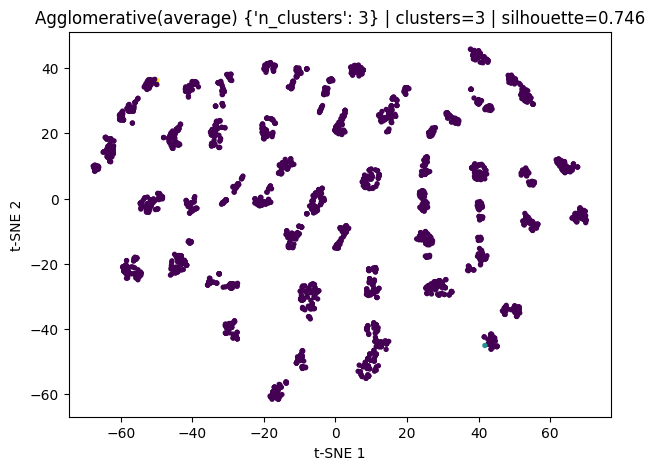

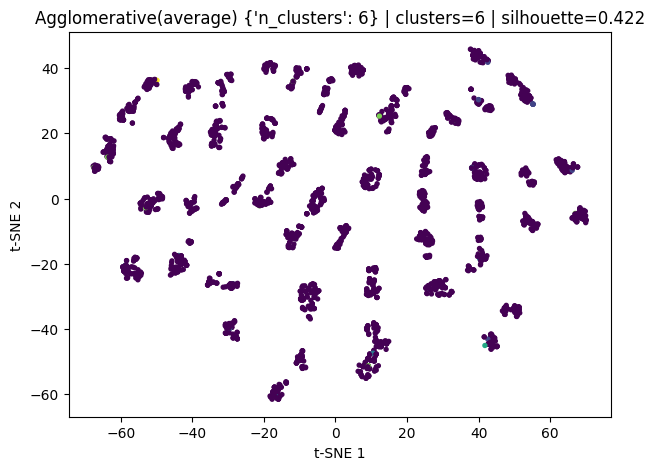

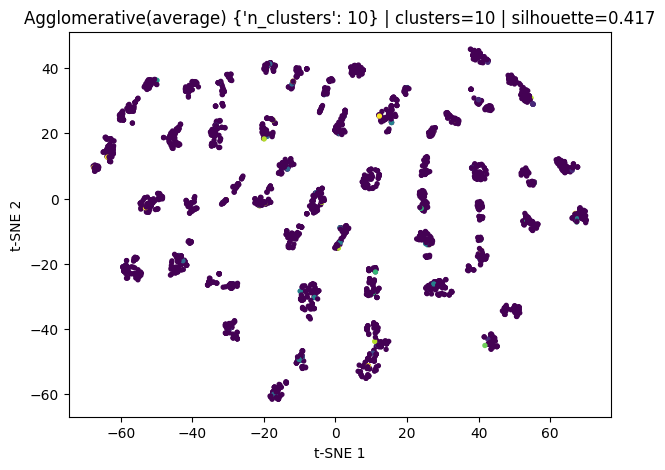

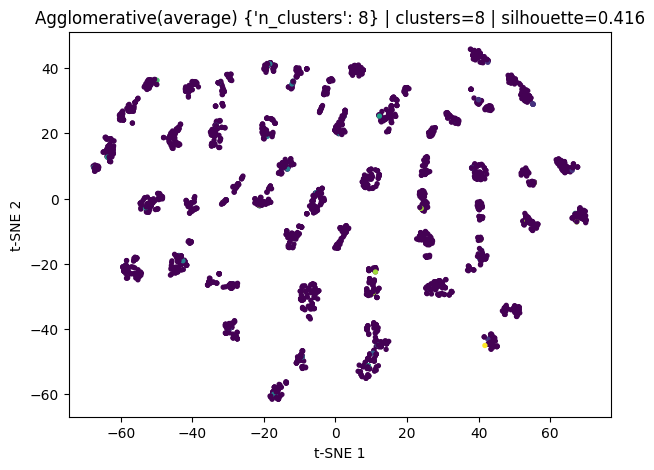

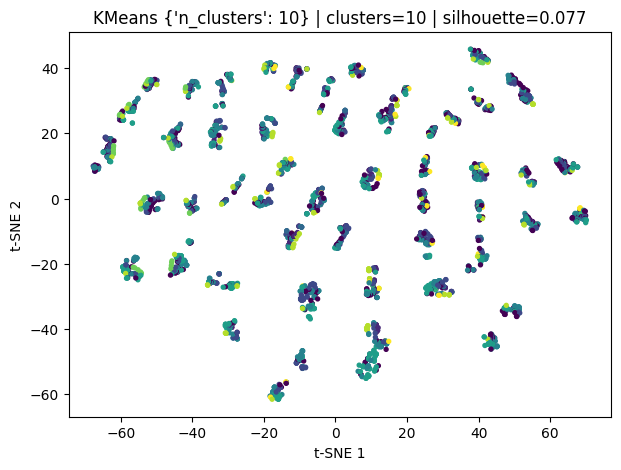

In [23]:

# == Визуализации кластеров ==
# Для топ-5 моделей по силуэту построим 2D-графики t-SNE

topn = 5
top_ids = metrics_df.head(topn)["model_id"].tolist()

for mid in top_ids:
    labels = labels_list[mid]
    fig = plt.figure(figsize=(7, 5))
    plt.scatter(X_2d[:,0], X_2d[:,1], c=labels, s=8)
    row = metrics_df.loc[metrics_df["model_id"]==mid].iloc[0]
    ttl = f"{row['model']} {row['params']} | "           f"clusters={int(row['n_clusters'])} | silhouette={row['silhouette']:.3f}"
    plt.title(ttl)
    plt.xlabel("t-SNE 1")
    plt.ylabel("t-SNE 2")
    plt.show()


In [24]:

# == Простейшие описатели кластеров по 'purpose' ==
# Возьмем лучшую модель по силуэту и посмотрим частотность слов в 'purpose' по кластерам.

best_id = metrics_df.iloc[0]["model_id"]
best_labels = labels_list[int(best_id)]
tmp = work_df.copy()
tmp["cluster"] = best_labels

def top_terms_per_cluster(df, text_col="purpose", topk=10):
    from collections import Counter
    rows = []
    word_re = re.compile(r"[\w\d\-]+", re.U)
    for c, part in df.groupby("cluster"):
        tokens = []
        for txt in part[text_col].astype(str).tolist():
            tokens.extend(w.lower() for w in word_re.findall(txt))
        cnt = Counter(tokens)
        top = cnt.most_common(topk)
        rows.append({
            "cluster": c,
            "size": len(part),
            "top_terms": ", ".join([f"{w}({n})" for w, n in top])
        })
    return pd.DataFrame(rows).sort_values("size", ascending=False)

cluster_summary = top_terms_per_cluster(tmp, text_col="purpose", topk=10)
cluster_summary


,cluster,size,top_terms
0,0,2686,"от(3256), по(1931), ндс(1874), за(1696), без(1311), договору(1143), сумма(1126), в(900), оплата(867), 02(862)"
1,1,1,"за(3), 12(3), 2022(2), 31(2), комиссия(1), ведение(1), счета(1), acc_ded93f97f389(1), от(1), 02(1)"
2,2,1,"за(3), 12(3), 2019(2), 31(2), комиссия(1), ведение(1), счета(1), acc_ded93f97f389(1), от(1), 02(1)"


In [ ]:

# == Экспорт результатов ==
OUT_DIR = "/mnt/data"
metrics_path = os.path.join(OUT_DIR, "clustering_metrics.csv")
labels_path = os.path.join(OUT_DIR, "clustering_labels_best.csv")

metrics_df.to_csv(metrics_path, index=False)
pd.DataFrame({"label": best_labels}).to_csv(labels_path, index=False)

print("Сохранено:")
print(metrics_path)
print(labels_path)



## Как запустить на ваших данных

1. Подготовьте CSV с колонками: `date, debit_account, debit_name, debit_inn, credit_account, credit_name, credit_inn, purpose`  
2. Положите файл, например, в `/mnt/data/transactions.csv` (или задайте переменную окружения `TX_CSV_PATH`).  
3. Запустите все ячейки сверху вниз.  
4. Смотрите таблицу метрик, графики и экспорт в `/mnt/data/`.
